In [1]:
import glob
import regex
import Levenshtein
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from elasticsearch import Elasticsearch
from elasticsearch.helpers import parallel_bulk, bulk
from bisect import bisect
from spacy.tokenizer import Tokenizer
from spacy.lang.pl import Polish

In [2]:
PATH = '../lab1/ustawy/'
file_names = sorted(glob.glob(PATH + "*"))
file_names[:5]

['../lab1/ustawy/1993_599.txt',
 '../lab1/ustawy/1993_602.txt',
 '../lab1/ustawy/1993_645.txt',
 '../lab1/ustawy/1993_646.txt',
 '../lab1/ustawy/1994_150.txt']

In [3]:
law_acts =[]
for file_name in file_names:
    with open(file_name, "r", encoding="utf-8") as f:
        law_acts.append(f.read().lower())

# Zadanie 1

Tokenizacja każdego projektu ustawy przy użyciu tokenizera spacy

In [4]:
lang = Polish()
tokenizer = Tokenizer(lang.vocab)

In [5]:
%%time
tokens_per_act = []

for law_act in law_acts:
    tokens_per_act.append(tokenizer(law_act))

CPU times: user 38.2 s, sys: 624 ms, total: 38.8 s
Wall time: 39.2 s


# Zadanie 2

Obliczenie słownika częstotliwości występowania tokenów w poszczególnych projektach ustaw

In [6]:
%%time
frequency_list_per_act = []

for tokens in tokens_per_act:
    unique_tokens, counts = np.unique([token.string.strip() for token in tokens], return_counts=True)
    frequency_list = {unique_token: count for unique_token, count in zip(unique_tokens, counts)}
    frequency_list_per_act.append(frequency_list)

CPU times: user 11.1 s, sys: 308 ms, total: 11.4 s
Wall time: 11.4 s


# Zadanie 3

Agregacja wyników zadania 2 w celu uzyskania słownika częstotliwości występowania tokenów we wszystkich dokumentach

In [7]:
%%time
global_frequency = {}

for frequency_list in frequency_list_per_act:
    for token, count in frequency_list.items():
        prev_count = global_frequency.get(token, 0)
        global_frequency[token] = prev_count + count

CPU times: user 976 ms, sys: 3.96 ms, total: 980 ms
Wall time: 980 ms


# Zadanie 4

Odrzucenie tokenów krótszych niż 2 znaki, lub zawierających nie litery

In [8]:
%%time
new_global_frequency = {}

for token, count in global_frequency.items():
    if token.isalpha() and len(token) >= 2:
        new_global_frequency[token] = count
global_frequency = new_global_frequency

CPU times: user 85 ms, sys: 144 µs, total: 85.2 ms
Wall time: 89 ms


In [9]:
global_frequency['być']

6045

# Zadanie 5

In [10]:
items = list(global_frequency.items())
items[:5]

[('akcesoria', 5),
 ('akcyzowych', 334),
 ('akcyzowym', 67),
 ('akcyzy', 471),
 ('akcyzą', 40)]

Listę tokenów sortuję zgodnie z kluczem składającym się z liczby przeciwnej do liczby wystąpień tokenu i pisowni tokenu. Pierwsza część zapewnia ułożenie tokenów od najczęściej występujących, a druga alfabetyczne posortowanie tokenów występujących tyle samo razy

In [11]:
items.sort(key=lambda item: (-item[1], item[0]))
items[:5]

[('do', 60402), ('na', 50395), ('lub', 45625), ('nr', 45125), ('się', 44137)]

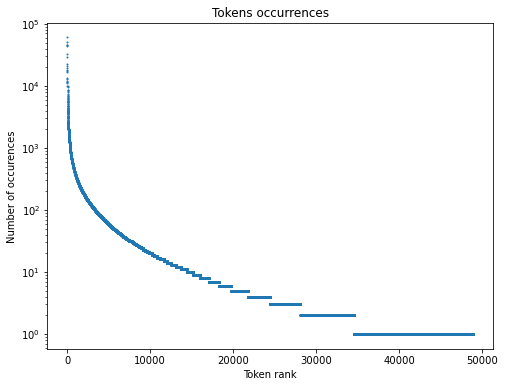

CPU times: user 1.84 s, sys: 32.2 ms, total: 1.87 s
Wall time: 1.93 s


In [12]:
%%time
plt.figure(figsize=(8, 6))
plt.yscale('log')
plt.scatter(list(range(len(items))), [item[1] for item in items], s=1)
plt.title('Tokens occurrences')
plt.xlabel('Token rank')
plt.ylabel('Number of occurences')
plt.show()

# Zadanie 6

Najpierw wczytuje i sortuje wszystkie formy słów dostępne w polimorfiku

In [13]:
%%time
MORFOLOGIK_PATH = '../polimorfologik-2.1/polimorfologik-2.1.txt'
morfologik_words =[]
with open(MORFOLOGIK_PATH, "r", encoding="utf-8") as f:
    line = f.readline()
    while line:
        morfologik_words.append(line.split(';')[1].lower())
        line = f.readline()
morfologik_words = sorted(np.unique(morfologik_words))

CPU times: user 13.8 s, sys: 2.84 s, total: 16.6 s
Wall time: 18 s


In [14]:
morfologik_words[300:305]

['abażuru', 'abażury', 'abażurze', 'abażurów', 'abb']

Binsearchem sprawdzam, które z tokenów nie występują w słowniku

In [15]:
def is_in_list(listt, x):
    index = bisect(listt, x)
    if index == 0:
        return False
    return listt[index-1] == x

In [16]:
%%time
missing_items = [item for item in global_frequency.items() if not is_in_list(morfologik_words, item[0])]
missing_items[:10]

CPU times: user 313 ms, sys: 112 µs, total: 313 ms
Wall time: 314 ms


[('gryzaczki', 1),
 ('kabelkowe', 1),
 ('odpodatkowania', 1),
 ('sww', 72),
 ('wadociągowych', 1),
 ('iv', 148),
 ('ix', 27),
 ('uchybionych', 1),
 ('vi', 87),
 ('vii', 64)]

# Zadanie 7

Wyświetlenie 30 najczęściej występujących słów, których nie ma w słowniku. Znów używam sortowania wg klucza opisanego w zadaniu 5 

In [17]:
missing_items.sort(key=lambda item: (-item[1], item[0]))
missing_items[:30]

[('gmo', 192),
 ('skw', 184),
 ('sa', 182),
 ('ex', 155),
 ('iv', 148),
 ('ike', 116),
 ('vi', 87),
 ('kn', 84),
 ('cn', 77),
 ('uke', 74),
 ('ure', 74),
 ('sww', 72),
 ('vii', 64),
 ('phs', 52),
 ('udt', 52),
 ('remediacji', 51),
 ('bswsg', 42),
 ('bswp', 39),
 ('viii', 34),
 ('pkwiu', 29),
 ('fep', 27),
 ('ix', 27),
 ('pcn', 27),
 ('ose', 26),
 ('uokik', 26),
 ('doręczeń', 25),
 ('frd', 25),
 ('plk', 25),
 ('inulinowego', 24),
 ('xi', 24)]

# Zadanie 8

Znalezienie 30 słów spoza słownika, które występują dokładnie 5 razy (korzystam z posortowanej wcześniej listy, więc otrzymam alfabetycznie posortowane słowa)

In [18]:
missing_items_with_5_occurences = [missing_item for missing_item in missing_items if missing_item[1] == 5]
missing_items_with_5_occurences[:30]

[('agave', 5),
 ('ami', 5),
 ('anonimizacji', 5),
 ('badawczorozwojowych', 5),
 ('dostosowań', 5),
 ('iib', 5),
 ('izobutyl', 5),
 ('jed', 5),
 ('ktrej', 5),
 ('najmnie', 5),
 ('naliczeń', 5),
 ('nawodnień', 5),
 ('nawozw', 5),
 ('nfośigw', 5),
 ('nusp', 5),
 ('odgazowywacze', 5),
 ('odwzorowań', 5),
 ('ośc', 5),
 ('poddziałań', 5),
 ('ponadzakładowym', 5),
 ('pozaaptecznego', 5),
 ('ppkt', 5),
 ('przepisw', 5),
 ('próbobiorców', 5),
 ('regazyfikacyjnego', 5),
 ('rekapitalizacyjnej', 5),
 ('rozmnożeń', 5),
 ('sanitarnoepidemiologicznych', 5),
 ('sposb', 5),
 ('teryto', 5)]

# Zadanie 9

Szukam potencjalnych poprawek słów na początek filtrując wszystkie wyrazy z listy częstotliwości aby ich odległość Levenshtein'a od wyrazu poprawianego nie była większa niż 5 i aby na pewno należały do morfologika. Następnie sortuje poprawki według klucza log(liczba_wystąpień_tokenu) / odległość_tokenu_od_słowa_poprawianego. Taki klucz pozwala brać pod uwagę nieco bardziej wyrazy występujące często, przy zachowaniu dużego spadku istotności dla wyrazów mocno różniących się od wyrazów poprawianych. Zapisuję jako wynik 3 najlepsze wg opisanego klucza poprawki.

In [19]:
def calculate_best_corrections(missing_word, max_distance=5, corrections_no=3):
    potential_corrections = list(filter(
        lambda item: is_in_list(morfologik_words, item[0]) and Levenshtein.distance(item[0], missing_word) <= max_distance, 
        items))
    best_corrections = sorted(
        potential_corrections, 
        key=lambda item: (np.log(item[1]) / Levenshtein.distance(missing_word, item[0]), item[0]), 
        reverse=True
    )
    return best_corrections[:corrections_no]

In [20]:
calculate_best_corrections('urok')

[('rok', 1181), ('roku', 3123), ('do', 60402)]

In [21]:
missing_items_with_5_occurences_corrections = {}
for missing_item in missing_items_with_5_occurences[:30]:
    missing_items_with_5_occurences_corrections[missing_item] = calculate_best_corrections(missing_item[0])
missing_items_with_5_occurences_corrections

{('agave', 5): [('na', 50395), ('oraz', 33184), ('nie', 22965)],
 ('ami', 5): [('ani', 430), ('dni', 3237), ('mi', 56)],
 ('anonimizacji', 5): [('aktualizacji', 155),
  ('lokalizacji', 117),
  ('mobilizacji', 44)],
 ('badawczorozwojowych', 5): [],
 ('dostosowań', 5): [('dostosować', 30),
  ('postępowań', 192),
  ('stosować', 172)],
 ('iib', 5): [('ii', 342), ('iii', 244), ('lub', 45625)],
 ('izobutyl', 5): [('izby', 1001), ('osoby', 3578), ('kwoty', 1856)],
 ('jed', 5): [('jej', 3695), ('je', 645), ('od', 16690)],
 ('ktrej', 5): [('której', 7473), ('które', 4029), ('tej', 2948)],
 ('najmnie', 5): [('najmniej', 2384), ('najmie', 42), ('nadanie', 221)],
 ('naliczeń', 5): [('odliczeń', 113), ('zaliczek', 89), ('nie', 22965)],
 ('nawodnień', 5): [('zgodnie', 2630), ('najmniej', 2384), ('narodowej', 846)],
 ('nawozw', 5): [('nawozu', 134), ('nawozy', 112), ('nawozów', 89)],
 ('nfośigw', 5): [('nie', 22965), ('niż', 6436), ('środków', 3906)],
 ('nusp', 5): [('na', 50395), ('lub', 45625), ('n

# Zadanie 10

Tworzę index

In [22]:
es = Elasticsearch()

In [23]:
es.indices.create(
    index="custom_index",
    body={
        "settings": {
            "analysis": {
                "analyzer": {
                  "custom_analyzer": {
                      "type": "custom",
                      "tokenizer": "standard",
                      "filter": ["morfologik_stem", "lowercase"]
                    }
                }
            }
        },
        "mappings": {
            "properties": {
                "morfologik_word": {
                    "type": "text",
                    "analyzer": "custom_analyzer"
                }
            }
        }
    }
)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'custom_index'}

In [24]:
# es.indices.delete(index="custom_index")

Przygotowuję operacje dodawania wyrazów do indeksu korzystając z helpera bulk, bez niego dodawanie zajęłoby mi około 6 godzin 

In [25]:
def morfologik_words_gen():
    for word in morfologik_words:
         yield {
                "_index": "custom_index",
                "morfologik_word": word,
            }
        
parallel_bulk_additions = parallel_bulk(es, morfologik_words_gen())

In [26]:
%%time
for success, info in parallel_bulk_additions:
    if not success:
        print('A document failed:', info)

CPU times: user 4min 49s, sys: 13.1 s, total: 5min 2s
Wall time: 4min 59s


Wyszukuję korzystając z fuzzy query słowa najbardziej odpowiadające słowom spoza morfologika, zapisuje po 3 z najwyższym scorem

In [27]:
missing_items_with_5_occurences_es_corrections = {}
for missing_item in missing_items_with_5_occurences[:30]:
    hits = es.search(
        body={
            "query": {
                "fuzzy": {
                    "morfologik_word": {
                        "value": missing_item[0],
                        "fuzziness": 10
                    } 
                }
            }
        },
        index="custom_index"
    )["hits"]["hits"][:3]
    missing_items_with_5_occurences_es_corrections[missing_item] = [hit["_source"]["morfologik_word"] for hit in hits]
missing_items_with_5_occurences_es_corrections

{('agave', 5): ['agape', 'agato', 'agaw'],
 ('ami', 5): ['abb-ami', 'abs-ami', 'adn-ami'],
 ('anonimizacji', 5): [],
 ('badawczorozwojowych', 5): [],
 ('dostosowań', 5): ['dostosowaliśmy', 'dostosowane', 'dostosowanego'],
 ('iib', 5): ['bicie', 'bili', 'bity'],
 ('izobutyl', 5): ['izobutan', 'izobutanach', 'izobutanami'],
 ('jed', 5): ['bed', 'jej', 'jen'],
 ('ktrej', 5): ['krojach', 'krojem', 'krojom'],
 ('najmnie', 5): ['najemnie', 'najmanie', 'najmniej'],
 ('naliczeń', 5): ['naliczki', 'naliczek', 'naliczka'],
 ('nawodnień', 5): ['nienawodniająca', 'nienawodniające', 'nienawodniającego'],
 ('nawozw', 5): ['nawozowi', 'nawiewem', 'nawiewowi'],
 ('nfośigw', 5): [],
 ('nusp', 5): ['kuso', 'nasi', 'naszych'],
 ('odgazowywacze', 5): [],
 ('odwzorowań', 5): ['nieodwzorowana', 'nieodwzorowane', 'nieodwzorowanego'],
 ('ośc', 5): ['kościom', 'kośćmi', 'lężenia'],
 ('poddziałań', 5): ['nieoddziałania', 'nieoddziałanie', 'nieoddziałaniem'],
 ('ponadzakładowym', 5): [],
 ('pozaaptecznego', 5): 

# Zadanie 11 i 12

In [28]:
corrections = {}
for item, es_corrections in missing_items_with_5_occurences_es_corrections.items():
    corrections[item[0]] = (";  ".join(es_corrections), ";  ".join([i[0] for i in missing_items_with_5_occurences_corrections[item]]))
pd.DataFrame.from_dict(corrections, orient='index', columns=['ES fuzzy corrections', 'My corrections'])

,ES fuzzy corrections,My corrections
agave,agape; agato; agaw,na; oraz; nie
ami,abb-ami; abs-ami; adn-ami,ani; dni; mi
anonimizacji,,aktualizacji; lokalizacji; mobilizacji
badawczorozwojowych,,
dostosowań,dostosowaliśmy; dostosowane; dostosowanego,dostosować; postępowań; stosować
iib,bicie; bili; bity,ii; iii; lub
izobutyl,izobutan; izobutanach; izobutanami,izby; osoby; kwoty
jed,bed; jej; jen,jej; je; od
ktrej,krojach; krojem; krojom,której; które; tej
najmnie,najemnie; najmanie; najmniej,najmniej; najmie; nadanie


(Dataframe pandas wyświetla się paskudnie w pdf'ie, dlatego wrzuciłem screen w plikach zadania)

Obie metody wyszukiwania poprawek pozwoliły uzyskać zadowalające wyniki. Każda z nich miała swoje plusy, choć wydaj mi się, że w kontekście tego konkretnego zadania moja metoda dała nieco lepsze rezultaty.

Draw conclusions regarding the distribution of words in the corpus:
Przeglądając poprawki uzyskane przy pomocy ES widzimy wiele słów, które praktycznie nie występują w naszym korpusie (np. izobutyl-izobutan). Ze względu na sposób działania moja metoda zwraca słowa częściej występujące w projektach ustaw (np. izobutyl-izby).

Draw conclusions regarding the number of true misspellings vs. the number of unknown words:
Wśród rozpatrywanych słów występują takie, które w oczywisty sposób rozpoznajemy jako literówki (np. sposb, przepisw). Większości literówki wydają się dotyczyć słów, które nie występują rzadko. Z tego względu lepiej radzi sobie z nimi moja metoda znajdywania poprawek. Niestety większość rozpatrywanych słów spoza słownika to słowa błędnie skonstruowane, nieistniejące, albo skróty. Znajdywane dla nich poprawki tylko w niektórych przypadkach wydają się być odpowiednie.

Draw conclusions regarding the performance of your method compared to ElasitcSearch:
ElasticSearch wymaga długotrwałego setupu (nawet po wykorzystaniu parallel_bulk), ale potem pozwala otrzymywać wyniki bardzo szybko. Moja metoda działa dość szybko (dzięku temu, że najpierw odfiltrowywuje słowa spełniające warunek max_distance, a dopiero później sortuje wg dobrego klucza), choć zauważalnie wolniej niż ES i posiada szybszy setup (przy założeniu, że wykonuje się już przygotowane instrukcje, a nie wymyśla je od nowa).

Draw conclusions regarding the results provided by your method compared to ElasticSearch:
Wydaje się, że moja metoda uzyskuje lepsze rezultaty, przykładowo poprawka do 'jed' - 'jad', otrzymana przy pomocy ES brzmi dobrze, ale nie uwzględnia tego, że słowo jad raczej nie pojawia się w projektach ustaw, a słowo 'jej' będące korektą zwróconą przez moją metodę wydaje się bardziej prawdopodobną poprawką. Podobnie jest z innymi słowami. Ponadto wyniki uzyskane przy pomocy ES częściej są puste. Prawdopodobnie dopasowywanie parametru fuzziness do konkretnych błędów mogłoby to poprawić, ale spowodowałoby konieczność przerobienia algorytmów na semi-automatyczne (już i tak użyłem dość wysokiej wartości tego parametru - 10).

Draw conclusions regarding the validity of the obtained corrections:
Wyniki uzyskane przy pomocy mojej metody wydają się być bardziej adekwatne do tego, co może się znaleźć w projektach ustaw.